In [ ]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap, HeatMapWithTime

## Import and check data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/PAPI NASONOV/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/PAPI NASONOV/test.csv')
valid = pd.read_csv('/content/drive/MyDrive/PAPI NASONOV/valid.csv')

In [ ]:
train.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


In [ ]:
valid.rename(columns={'hour':'timestamp'}, inplace=True)
print(valid.shape)
valid.head()

(709, 6)


,timestamp,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [ ]:
test.rename(columns={'hour': 'timestamp'}, inplace=True)
print(test.shape)
test.head()

(700, 6)


,timestamp,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069


##General info

In [ ]:
print(f"train size: {len(train)}")
print(f"valid size: {len(valid)}")
print(f"test size: {len(test)}")

train size: 8526526
valid size: 709
test size: 700


In [ ]:
print(f"train unique points: {len(train.groupby(['lon','lat'])['point'].count())}")
print(f"valid unique points: {len(valid.groupby(['lon','lat'])['point'].count())}")
print(f"test unique points: {len(test.groupby(['lon','lat'])['point'].count())}")

train unique points: 7041
valid unique points: 155
test unique points: 149


In [ ]:
print("min time: " + str(pd.to_datetime(train['timestamp'], unit='s').min()))
print("max time: " + str(pd.to_datetime(train['timestamp'], unit='s').max()))

min time: 2019-01-01 00:00:00
max time: 2020-01-31 23:00:00


In [ ]:
print(f"Valid MAE: {sum(valid.error) / len(valid)}, MSE: {sum(pow(valid.error, 2)) / len(valid)}")
print(f"Test MAE: {sum(test.error) / len(test)}, MSE: {sum(pow(test.error, 2)) / len(test)}")

Valid MAE: 2.596415041635585, MSE: 21.292534500455698
Test MAE: 2.620661985724118, MSE: 23.28762459510085


## Visualise on map
Точки в большинстве расположены в СПБ и ЛенОбласти

In [ ]:
valid_points = valid.groupby(['lon','lat'])['timestamp'].count().reset_index().sort_values('timestamp')

In [ ]:
valid_points

,lon,lat,timestamp
154,30.535982,59.828934,1
97,30.338353,59.940488,1
34,30.293437,59.944987,1
35,30.295683,59.862778,1
36,30.295683,59.914604,1
...,...,...,...
138,30.425939,59.899966,17
56,30.311403,59.966350,18
83,30.324878,59.933737,19
145,30.468609,59.921359,19


In [ ]:
train_points = train.loc[:, ['lon','lat','point']].groupby(['lon','lat']).count().reset_index()

In [ ]:
train_points

,lon,lat,point
0,-48.410211,-1.390007,107
1,0.000000,0.000000,74415
2,18.846655,42.289870,15
3,20.486080,54.715007,1
4,23.690820,52.116679,335
...,...,...,...
7036,40.251262,43.689392,1
7037,41.021567,42.996900,852
7038,62.098290,57.451661,2
7039,69.289304,41.303760,37


In [ ]:
train_points_spb = train_points.query('lat>59.5&lat<60.5&lon>30&lon<31')
train_points_other = train_points.query('lat<59.5|lat>60.5|lon<30|lon>31')

In [ ]:
len(train_points_spb)

7024

In [ ]:
train_points_spb.sort_values('point')

,lon,lat,point
6099,30.461871,59.879687,1
5367,30.416956,60.033724,1
6368,30.477592,59.850372,1
5376,30.419201,59.839091,1
4239,30.367548,60.015771,1
...,...,...,...
2932,30.315895,59.950610,115011
2543,30.300175,59.949486,118465
2867,30.313649,59.939363,120424
1232,30.241784,59.924735,145191


In [ ]:
len(train_points_other)

17

In [ ]:
import math
def sq250(coords):
  ang_lat = 0.0625 / 110.574
  ang_lon = 2 * 0.0625 / (111.320 * math.cos(coords[0] / math.pi / 180))
  return [(coords[0] + ang_lat, coords[1] + ang_lon),
          (coords[0] - ang_lat, coords[1] - ang_lon)]

In [ ]:
m = folium.Map([59.938641, 30.31418],
               #tiles = "Stamen Toner",
               zoom_start=12)

folium.TileLayer("openstreetmap").add_to(m)

#style = {'fillColor': '#00000000', 'color': '#00550055'}

outline = '/content/drive/MyDrive/PAPI NASONOV/sbp.geojson.txt'

folium.GeoJson(outline, name='outline',
               style_function=lambda x: {'fillColor': '#00000000', 'color': '#005555FF'},
               show=True).add_to(m)

HeatMap(train_points_spb.loc[:, ['lat','lon','point']], 
        min_opacity=0.1,
        blur = 5).add_to(m)
   # m.save('cafes.html')

m

In [ ]:
len(train_points_other)

17

In [ ]:
m = folium.Map(location=(59.93863, 30.31413), tiles=None, zoom_start=2)

folium.TileLayer("openstreetmap").add_to(m)

for coords in train_points_other[['lat','lon']].values:
  folium.Marker(tuple(coords)).add_to(m)

m

In [ ]:
valid.head()

,timestamp,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [ ]:
test.head()

,timestamp,lat,lon,point,sum,error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069


## Build train sample

In [ ]:
#trainset = train.copy()
short_trainset = train[['lon','lat','point', 'timestamp', 'likescount']].groupby(['point','lat','lon','timestamp']).count().reset_index()
short_trainset = short_trainset.rename(columns={'likescount': 'publication'})
short_trainset.to_csv('short_trainset.csv')

In [ ]:
short_trainset.head()

,point,lat,lon,timestamp,publication
0,0101000020E61000000000000000000000000000000000...,0.0,0.0,1546300800,3
1,0101000020E61000000000000000000000000000000000...,0.0,0.0,1546304400,2
2,0101000020E61000000000000000000000000000000000...,0.0,0.0,1546308000,2
3,0101000020E61000000000000000000000000000000000...,0.0,0.0,1546318800,3
4,0101000020E61000000000000000000000000000000000...,0.0,0.0,1546322400,2


### Check relation point-coords

In [ ]:
short_trainset_1 = short_trainset.copy()
short_trainset_1['coords'] = short_trainset_1['lon'].astype('str')+'-'+short_trainset_1['lat'].astype('str')

In [ ]:
# check relation point-coords
short_trainset_1.groupby(['point'])['coords'].nunique().reset_index(name='count').sort_values('count')

,point,count
0,0101000020E61000000000000000000000000000000000...,1
4699,0101000020E6100000AC1A327F9D6D3E408FAA9F16E404...,1
4698,0101000020E6100000AC1A327F9D6D3E407916A554F5F8...,1
4697,0101000020E6100000AC1A327F9D6D3E4074DD5BB2DBED...,1
4696,0101000020E6100000AC1A327F9D6D3E406E4CE6811AEA...,1
...,...,...
2341,0101000020E6100000544263A8C4573E40516FA59DABF8...,1
2340,0101000020E6100000544263A8C4573E405009D46AD3EA...,1
2339,0101000020E6100000544263A8C4573E404983611E77F1...,1
2350,0101000020E6100000544263A8C4573E407F614299EAF3...,1


### Check coords
* nice lat 59-61
* nice lon 29-31

In [ ]:
nice_short_trainset = short_trainset.query('lat>59&lat<61&lon>29&lon<31')

In [ ]:
nice_short_trainset.head()

,point,lat,lon,timestamp,publication
8470,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.11602,1574420400,1
8471,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.11602,1574424000,1
8472,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.11602,1574514000,1
8473,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.11602,1574697600,1
8474,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.11602,1574848800,1


In [ ]:
nice_short_trainset.sort_values('publication', )

,point,lat,lon,timestamp,publication
8470,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,59.835705,30.116020,1574420400,1
2114205,0101000020E61000009757507A31573E40CEB8CE2B18F8...,59.938238,30.340599,1564477200,1
2114208,0101000020E61000009757507A31573E40CEB8CE2B18F8...,59.938238,30.340599,1564516800,1
2114210,0101000020E61000009757507A31573E40CEB8CE2B18F8...,59.938238,30.340599,1564563600,1
2114211,0101000020E61000009757507A31573E40CEB8CE2B18F8...,59.938238,30.340599,1564574400,1
...,...,...,...,...,...
1239632,0101000020E6100000597DBB518C333E400262E887FEFD...,59.984330,30.201360,1563742800,426
1079724,0101000020E610000050D352C225383E4030E11C588EFC...,59.973094,30.219326,1570903200,428
1080504,0101000020E610000050D352C225383E4030E11C588EFC...,59.973094,30.219326,1573923600,442
1079879,0101000020E610000050D352C225383E4030E11C588EFC...,59.973094,30.219326,1571504400,443


### Feature Engineering

In [ ]:
from datetime import datetime

In [ ]:
short_train = nice_short_trainset.drop(['point'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
short_train.head()

,lat,lon,timestamp,publication
8470,59.835705,30.11602,1574420400,1
8471,59.835705,30.11602,1574424000,1
8472,59.835705,30.11602,1574514000,1
8473,59.835705,30.11602,1574697600,1
8474,59.835705,30.11602,1574848800,1


In [ ]:
short_train['date'] = pd.to_datetime(short_train['timestamp'], unit='s')

In [ ]:
short_train.head(3)

,lat,lon,timestamp,publication,date
8470,59.835705,30.11602,1574420400,1,2019-11-22 11:00:00
8471,59.835705,30.11602,1574424000,1,2019-11-22 12:00:00
8472,59.835705,30.11602,1574514000,1,2019-11-23 13:00:00


In [ ]:
short_train['timestamp'] = short_train['date'].apply(lambda x: x.hour)
short_train['day'] = short_train['date'].apply(lambda x: x.day)
short_train['month'] = short_train['date'].apply(lambda x: x.month)

In [ ]:
short_train.head()

,lat,lon,timestamp,publication,date,day,month
8470,59.835705,30.11602,11,1,2019-11-22 11:00:00,22,11
8471,59.835705,30.11602,12,1,2019-11-22 12:00:00,22,11
8472,59.835705,30.11602,13,1,2019-11-23 13:00:00,23,11
8473,59.835705,30.11602,16,1,2019-11-25 16:00:00,25,11
8474,59.835705,30.11602,10,1,2019-11-27 10:00:00,27,11


In [ ]:
short_train.to_csv('/content/drive/MyDrive/PAPI NASONOV/nice_train_on_baseline.csv', index=False)
short_train.head()

,lat,lon,timestamp,publication,date,day,month
8470,59.835705,30.11602,11,1,2019-11-22 11:00:00,22,11
8471,59.835705,30.11602,12,1,2019-11-22 12:00:00,22,11
8472,59.835705,30.11602,13,1,2019-11-23 13:00:00,23,11
8473,59.835705,30.11602,16,1,2019-11-25 16:00:00,25,11
8474,59.835705,30.11602,10,1,2019-11-27 10:00:00,27,11


### Baseline XGBOOST

In [ ]:
short_train = pd.read_csv('/content/drive/MyDrive/PAPI NASONOV/nice_train_on_baseline.csv')

In [ ]:
short_train['short_date'] = pd.to_datetime(short_train['date'])

# выходной
short_train['weekend'] = short_train['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

short_train.head()

,lat,lon,timestamp,publication,date,day,month,short_date,weekend
0,59.835705,30.11602,11,1,2019-11-22 11:00:00,22,11,2019-11-22 11:00:00,0
1,59.835705,30.11602,12,1,2019-11-22 12:00:00,22,11,2019-11-22 12:00:00,0
2,59.835705,30.11602,13,1,2019-11-23 13:00:00,23,11,2019-11-23 13:00:00,1
3,59.835705,30.11602,16,1,2019-11-25 16:00:00,25,11,2019-11-25 16:00:00,0
4,59.835705,30.11602,10,1,2019-11-27 10:00:00,27,11,2019-11-27 10:00:00,0


In [ ]:
short_train_no_date = short_train.drop(['date', 'short_date'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
short_train_no_date.head(2)

,lat,lon,timestamp,publication,day,month,weekend
0,59.835705,30.11602,11,1,22,11,0
1,59.835705,30.11602,12,1,22,11,0


In [ ]:
valid.head(2)

,timestamp,lat,lon,point,sum,error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291


In [ ]:
short_train_no_date = short_train_no_date[['lat', 'lon', 'timestamp', 'day', 'month','publication', 'weekend']]

In [ ]:
#X_train, X_valid, y_train, y_valid = train_test_split(short_train_no_date.drop(['publication'],1), short_train_no_date.publication, train_size=0.8, random_state=69)

In [ ]:
X_train, y_train = short_train_no_date.drop(['publication'],1), short_train_no_date.publication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
out_of_sample = test.copy().rename(columns={'sum':'publication'})

out_of_sample['date'] = pd.to_datetime(out_of_sample['timestamp'], unit='s')
out_of_sample['hour'] = out_of_sample['date'].apply(lambda x: x.hour)
out_of_sample['day'] = out_of_sample['date'].apply(lambda x: x.day)
out_of_sample['month'] = out_of_sample['date'].apply(lambda x: x.month)
# выходной
out_of_sample['short_date'] = pd.to_datetime(out_of_sample['date'])

# выходной
out_of_sample['weekend'] = out_of_sample['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

out_of_sample = out_of_sample[['lat', 'lon', 'timestamp', 'day', 'month','publication', 'weekend']]

X_test, y_test = out_of_sample.drop(['publication'],1), out_of_sample.publication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


In [ ]:
out_of_sample = valid.copy().rename(columns={'sum':'publication'})

out_of_sample['date'] = pd.to_datetime(out_of_sample['timestamp'], unit='s')
out_of_sample['hour'] = out_of_sample['date'].apply(lambda x: x.hour)
out_of_sample['day'] = out_of_sample['date'].apply(lambda x: x.day)
out_of_sample['month'] = out_of_sample['date'].apply(lambda x: x.month)
# выходной
out_of_sample['short_date'] = pd.to_datetime(out_of_sample['date'])

# выходной
out_of_sample['weekend'] = out_of_sample['short_date'].apply(lambda x: 1 if x.weekday()>=5 else 0)

out_of_sample = out_of_sample[['lat', 'lon', 'timestamp', 'day', 'month','publication', 'weekend']]

X_valid, y_valid = out_of_sample.drop(['publication'],1), out_of_sample.publication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


In [ ]:
baseline_model = XGBRegressor()

In [ ]:
baseline_model.fit(X_train, y_train)

valid_preds = baseline_model.predict(X_valid)
test_preds = baseline_model.predict(X_test)

[07:21:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
baseline_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
def custom_loss(true_val, pred_val):
  return abs(pred_val-true_val)/pred_val

In [ ]:
custom_loss(y_valid, valid_preds)

0      1.926604
1      1.366291
2      3.326204
3      2.938622
4      0.964328
         ...   
704    5.636066
705    0.622092
706    0.938831
707    3.253324
708    4.810008
Name: publication, Length: 709, dtype: float64

In [ ]:
print('VALID: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_valid, valid_preds),
                                                         mse(y_valid, valid_preds),
                                                         r2(y_valid, valid_preds),
                                                         np.mean(custom_loss(y_valid, valid_preds))))

print('TEST: mae {}, mse {}, r2 {}, custom_loss {}'.format(mae(y_test, test_preds),
                                                         mse(y_test, test_preds),
                                                         r2(y_test, test_preds),
                                                         np.mean(custom_loss(y_test, test_preds))))

VALID: mae 7.581254890926802, mse 92.81061663839543, r2 -1.2635326680772874, custom_loss 3.9311786561241253
TEST: mae 7.424402153577123, mse 91.30062805541039, r2 -1.2111588962613986, custom_loss 3.9248026590170433


In [ ]:
valid_display = valid[:700]

In [ ]:
valid_display['baseline_pred'] = test_preds
valid_display['baseline_error'] = custom_loss(y_test, test_preds)
valid_display.sort_values('baseline_error', ascending=True).head(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,timestamp,lat,lon,point,sum,error,baseline_pred,baseline_error
577,1582311600,60.016893,30.261996,0101000020E61000007D3FBA2D12433E40EC88DD902902...,5,0.245265,7.295053,0.040446
514,1582225200,59.833448,30.349582,0101000020E610000091029C327E593E40A08C1570AEEA...,6,0.754735,7.508933,0.065398
579,1582207200,59.938238,30.318141,0101000020E6100000202C93AD71513E40CEB8CE2B18F8...,16,4.088069,5.916431,0.154896
344,1581778800,0.000000,0.000000,0101000020E61000000000000000000000000000000000...,21,0.850014,7.295053,0.177525
104,1581314400,59.938238,30.331616,0101000020E61000009BAC04C2E4543E40CEB8CE2B18F8...,7,2.254735,7.295053,0.177525
639,1581346800,59.934863,30.329370,0101000020E6100000DBC1F19351543E40DB251193A9F7...,12,1.154735,5.916431,0.183146
683,1581523200,59.916856,30.318141,0101000020E6100000202C93AD71513E407A441D895BF5...,7,1.088069,7.508933,0.198572
167,1580727600,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,6,1.754735,7.508933,0.200952
41,1582826400,59.932612,30.250767,0101000020E6100000C1A95B4732403E40494A4ED65FF7...,9,1.773091,4.880724,0.229326
304,1581933600,59.933737,30.293437,0101000020E6100000EC15C3B21E4B3E407AB3D8B484F7...,6,1.919945,7.295053,0.233713


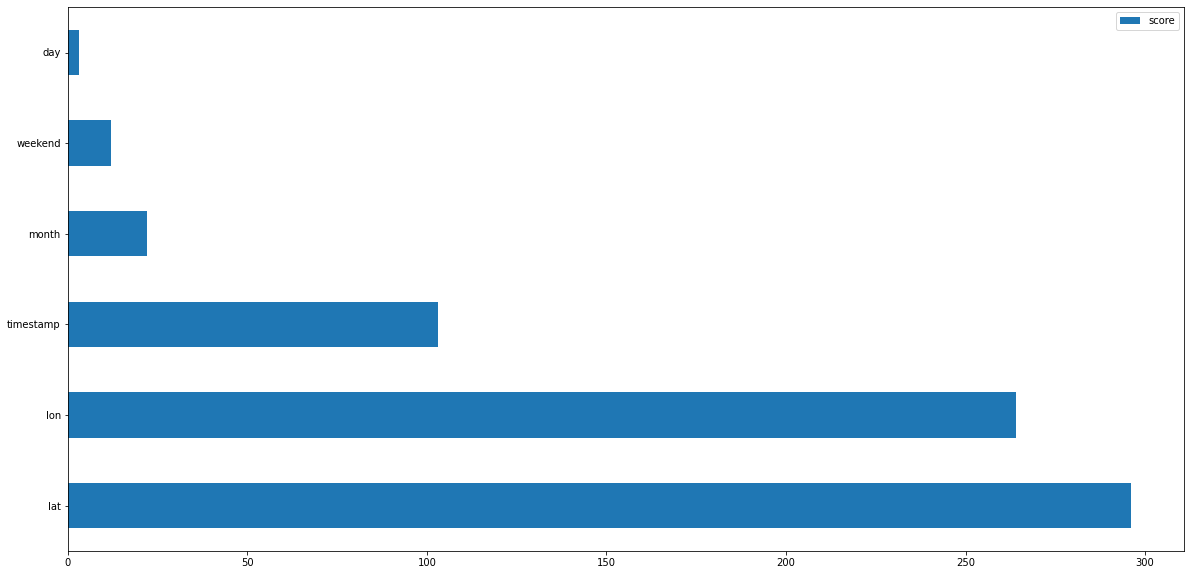

In [ ]:
feature_importants = baseline_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importants.keys())
values = list(feature_importants.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

In [ ]:
# Что делаем там где инфы
# Интерактивная карта по значениям - https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html
# Не хватает мета инфы прошлого
# Видно переобучение + возможно работали с ликами

In [ ]:
y_valid

0       5
1      14
2       5
3       7
4      14
       ..
704     7
705     8
706     6
707     8
708    11
Name: publication, Length: 709, dtype: int64

In [ ]:
print(len(X_valid))
print(len(y_valid))
print(len(valid_preds))

709
709
709


In [ ]:
p_num = 6
p_lat, p_lon = valid_display['lat'][p_num], valid_display['lon'][p_num]

p_df = valid_display[valid_display['lat'] == p_lat][valid_display['lon'] == p_lon]

p_df

#p_ypred = valid_preds[p_df.index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,timestamp,lat,lon,point,sum,error,baseline_pred,baseline_error
6,1581451200,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,13,1.354735,2.274132,3.397281
12,1581868800,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,28,0.991715,0.919012,4.440622
32,1582056000,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,10,2.088069,1.601551,6.492735
38,1581076800,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,20,3.754735,2.723896,2.671212
48,1581015600,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,23,3.354735,1.694109,3.722246
49,1581764400,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,17,1.157707,1.108743,3.509611
190,1582473600,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,28,0.334601,1.439358,3.863280
241,1581667200,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,24,10.754735,2.091683,3.302754
292,1582138800,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,12,0.754735,1.133799,3.409952
308,1581670800,59.929237,30.288946,0101000020E61000006E409D56F8493E400A41C338F1F6...,24,4.754735,1.880882,2.189993


# 11111111111111111

In [ ]:
!pip install -q pmdarima holidays catboost optuna

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 348 kB 54.0 MB/s 
     |████████████████████████████████| 9.9 MB 6.1 MB/s 
     |████████████████████████████████| 209 kB 60.3 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 50 kB 5.3 MB/s 
     |████████████████████████████████| 147 kB 27.5 MB/s 
     |████████████████████████████████| 112 kB 41.8 MB/s 


In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [ ]:
# eval
def metrics(prediction, ground_truth):
    return np.mean(np.abs(prediction - ground_truth) / prediction)

In [ ]:
catboost = CatBoostRegressor()
catboost.fit(X_train, y_train)

Learning rate set to 0.149472
0:	learn: 4.1187175	total: 1.19s	remaining: 19m 46s
1:	learn: 4.0869733	total: 1.89s	remaining: 15m 45s
2:	learn: 4.0605772	total: 2.7s	remaining: 14m 56s
3:	learn: 4.0393464	total: 3.54s	remaining: 14m 42s
4:	learn: 4.0256457	total: 4.29s	remaining: 14m 14s
5:	learn: 4.0090289	total: 5.22s	remaining: 14m 25s
6:	learn: 3.9969201	total: 5.94s	remaining: 14m 2s
7:	learn: 3.9895662	total: 6.71s	remaining: 13m 51s
8:	learn: 3.9798011	total: 7.58s	remaining: 13m 54s
9:	learn: 3.9682565	total: 8.38s	remaining: 13m 49s
10:	learn: 3.9629136	total: 9.28s	remaining: 13m 54s
11:	learn: 3.9446970	total: 10.3s	remaining: 14m 6s
12:	learn: 3.9370625	total: 11.8s	remaining: 14m 53s
13:	learn: 3.9242692	total: 13.1s	remaining: 15m 23s
14:	learn: 3.9134483	total: 14.2s	remaining: 15m 35s
15:	learn: 3.9006106	total: 15.4s	remaining: 15m 49s
16:	learn: 3.8866251	total: 16.3s	remaining: 15m 40s
17:	learn: 3.8836906	total: 17.1s	remaining: 15m 31s
18:	learn: 3.8809730	total: 1

In [ ]:
cat_pred = catboost.predict(X_valid)
metrics(cat_pred, y_valid)

7.538972314044675

In [ ]:
catboost.get_params()

{'loss_function': 'RMSE'}

In [ ]:
baseline_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
metrics(valid_preds, y_valid)

3.9311786561241253

In [ ]:
results = pd.DataFrame(np.array([y_valid, valid_preds, cat_pred, valid['error']]).T, columns=['ground_truth', 'xgb', 'catboost', 'base_error'])

In [ ]:
results['xgb_error'] = np.abs(results['xgb'] - results['ground_truth']) / results['xgb']
results['cat_error'] = np.abs(results['catboost'] - results['ground_truth']) / results['catboost']
results.head()

,ground_truth,xgb,catboost,base_error,xgb_error,cat_error
0,5.0,1.708465,1.019384,0.421402,1.926604,3.904925
1,14.0,5.916431,0.873856,0.310291,1.366291,15.020948
2,5.0,1.155748,1.069952,3.754735,3.326204,3.673106
3,7.0,1.777271,0.269333,0.504735,2.938622,24.990148
4,14.0,7.127120,8.765252,1.554735,0.964328,0.597216


In [ ]:
cat_pred_test = catboost.predict(X_test)
metrics(cat_pred_test, y_test)

0.9688970317391074

In [ ]:
train['sum'] = 1
train_grouped = train.groupby(['timestamp', 'point'], as_index=False).size()\
                    .sort_values('timestamp', ascending=True)\
                    .rename(columns={'size': 'sum'})
train_grouped.head()

,timestamp,point,sum
0,1546300800,0101000020E61000000000000000000000000000000000...,3
152,1546300800,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,1
153,1546300800,0101000020E61000009E01B90998523E40E4A1F770CEF7...,1
154,1546300800,0101000020E61000009EE75C6BAC303E401DAC68F66CFE...,1
155,1546300800,0101000020E6100000A4566D514B503E4006FC5DE561F8...,7


In [ ]:
points = list(set(list(train_grouped['point'].unique()) + list(valid['point'].unique())))
points = {k: v for v, k in enumerate(points)}

In [ ]:
import holidays

ru_holidays = holidays.Russia(years=[2019, 2020])

def is_holiday(date):
    weekday = date.weekday()
    if date in ru_holidays or weekday == 5 or weekday == 6:
        return 1
    else:
        return 0

# test feature engineering
test['date'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).date())
test['year'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).year)
test['month'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).month)
test['day'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).day)
test['weekday'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).weekday())
test['hour'] = test['timestamp'].map(lambda x: datetime.fromtimestamp(x).hour)
test['is_weekend'] = test['weekday'].map(lambda x: 1 if x > 4 and x < 7 else 0)
test['is_holiday'] = test['date'].map(is_holiday)
# encode location
test['point_new'] = test['point'].map(lambda x: points[x])

test.sort_values('timestamp', inplace=True)
test.head()

,timestamp,lat,lon,point,sum,error,date,year,month,day,weekday,hour,is_weekend,is_holiday,point_new
417,1580536800,59.931487,30.354073,0101000020E61000000FD8C18EA45A3E40CAE971F73AF7...,7,1.088069,2020-02-01,2020,2,1,5,6,1,1,6611
641,1580536800,59.893208,30.515770,0101000020E6100000C2DD138409843E4009249E9F54F2...,8,2.754735,2020-02-01,2020,2,1,5,6,1,1,6841
171,1580544000,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,13,0.379735,2020-02-01,2020,2,1,5,8,1,1,4553
167,1580551200,59.982083,30.199114,0101000020E61000009A92A823F9323E40DDC94EE7B4FD...,6,0.254735,2020-02-01,2020,2,1,5,10,1,1,6175
64,1580551200,60.039332,30.322632,0101000020E61000009E01B90998523E40888919D70805...,7,5.754735,2020-02-01,2020,2,1,5,10,1,1,979


In [ ]:
cat_pred_df = pd.DataFrame(cat_pred_test, columns=['sum_pred'])
cat_pred_df['date'] = test.date
cat_pred_df['lat'] = test.lat
cat_pred_df['lon'] = test.lon
cat_pred_df['timestamp'] = test.timestamp
cat_pred_df['point_new'] = test.point_new
cat_pred_df.head()

,sum_pred,date,lat,lon,timestamp,point_new
0,1.840663,2020-02-26,59.934863,30.331616,1582711200,5659
1,2.153053,2020-02-17,59.940488,30.329370,1581937200,5355
2,1.085791,2020-02-12,59.905597,30.297929,1581523200,5019
3,2.660729,2020-02-12,59.921359,30.356319,1581512400,4553
4,-0.187912,2020-02-15,59.939363,30.315895,1581771600,2750


In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(cat_pred_df, 
                        lat='lat', 
                        lon='lon',
                        zoom=9,
                        size='sum_pred',
                        height=500,
                        width=1000)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show()

ValueError: ignored

### Time-series approach - ARIMA?
* Time series - arima?

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 9.9 MB 42.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pmdarima
from tqdm import tqdm

In [ ]:
short_train

,lat,lon,timestamp,publication,date,hour,day,month,short_date,weekend
0,59.835705,30.116020,1574420400,1,2019-11-22 11:00:00,11,22,11,2019-11-22 11:00:00,0
1,59.835705,30.116020,1574424000,1,2019-11-22 12:00:00,12,22,11,2019-11-22 12:00:00,0
2,59.835705,30.116020,1574514000,1,2019-11-23 13:00:00,13,23,11,2019-11-23 13:00:00,1
3,59.835705,30.116020,1574697600,1,2019-11-25 16:00:00,16,25,11,2019-11-25 16:00:00,0
4,59.835705,30.116020,1574848800,1,2019-11-27 10:00:00,10,27,11,2019-11-27 10:00:00,0
...,...,...,...,...,...,...,...,...,...,...
3625575,59.898840,30.522508,1575604800,2,2019-12-06 04:00:00,4,6,12,2019-12-06 04:00:00,0
3625576,59.898840,30.522508,1577088000,1,2019-12-23 08:00:00,8,23,12,2019-12-23 08:00:00,0
3625577,59.870670,30.522508,1560157200,1,2019-06-10 09:00:00,9,10,6,2019-06-10 09:00:00,0
3625578,59.870670,30.522508,1570370400,1,2019-10-06 14:00:00,14,6,10,2019-10-06 14:00:00,1


In [ ]:
short_train_agg = train.query('lat>59.5&lat<60.5&lon>30&lon<31')
short_train_agg['publications'] = len(short_train_agg) * [1]
short_train_agg = short_train_agg.groupby(['timestamp', 'point'])\
                                 .agg({'publications':'sum','likescount':'sum',
                                       'commentscount':'sum','symbols_cnt':'sum',
                                       'words_cnt':'sum','hashtags_cnt':'sum',
                                       'mentions_cnt':'sum','links_cnt':'sum',
                                       'emoji_cnt':'sum','lat':'mean','lon':'mean'}).reset_index()

short_train_agg

,timestamp,point,publications,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,lat,lon
0,1546300800,0101000020E610000002BF48199F3F3E4010C569574E02...,1,49,2,41,3,0,0,0,0,60.018016,30.248521
1,1546300800,0101000020E610000002BF48199F3F3E40586790FFD8EC...,1,20,1,17,1,0,0,0,0,59.850372,30.248521
2,1546300800,0101000020E61000000614FD60523D3E400086058A8CFB...,1,40,0,0,0,0,0,0,0,59.965226,30.239538
3,1546300800,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2,141,2,19,2,0,0,0,1,59.858267,30.239538
4,1546300800,0101000020E61000000614FD60523D3E40D800D455BF04...,1,11,0,0,0,0,0,0,0,60.037089,30.239538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625535,1580511600,0101000020E6100000F26A77FAD1483E407916A554F5F8...,1,12,0,5,0,0,0,0,3,59.944987,30.284454
3625536,1580511600,0101000020E6100000F5A5CFA399243E40854A58CAE203...,1,47,11,198,18,0,0,0,2,60.030359,30.142969
3625537,1580511600,0101000020E6100000F5BF2B4285463E401AD725FD56F3...,2,23,0,0,0,0,0,0,0,59.901092,30.275471
3625538,1580511600,0101000020E6100000F914E08938443E407916A554F5F8...,1,18,0,0,0,0,0,0,0,59.944987,30.266488


In [ ]:
differs = list(set(valid['point'].unique().tolist()) - set(short_train_agg['point'].unique().tolist()))
valid = valid[valid['point'].isin(differs) == False]
valid[valid['point'] == valid['point'][0]].sort_values(by=['hour'])
valid

In [ ]:
custom_losses = []
preds = []

for poly_test in tqdm(valid['point'].unique().tolist()):
    
    train_df_loc = short_train_agg[short_train_agg['point'] == poly_test]

    train_df_loc = train_df_loc[-400:]
    model = pmdarima.arima.ARIMA(order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))

    y_train = train_df_loc['publications']
    test_df = valid[valid['point'] == poly_test].sort_values(by=['hour'])

    last_train = max(train_df_loc['timestamp'])
    last_test = max(test_df['hour'])

    dates_to_pred = list(range(last_train+3600,last_test+3600, 3600))
    model.fit(train_df_loc['publications'].tolist(), suppress_warnings = True)
    y_pred_test= model.predict(n_periods=len(dates_to_pred))

    pred_df = pd.DataFrame()
    pred_df['hour'] = dates_to_pred
    pred_df['prediction'] = y_pred_test.tolist()

    preds.append([pred_df['hour'].tolist(), pred_df['prediction'].tolist()])

    new_df = pd.merge(test_df, pred_df,  how='left', left_on=['hour'], right_on = ['hour'])
    y_pred_test = new_df['prediction']
    y_test = new_df['sum']

    custom_losses.append(np.mean(np.divide(np.abs(y_pred_test - y_test),y_pred_test)))

  0%|          | 0/154 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  1%|          | 1/154 [00:27<1:10:34, 27.68s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  1%|▏         | 2/154 [00:52<1:05:34, 25.88s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  2%|▏         | 3/154 [01:17<1:03:58, 25.42s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  3%|▎         | 4/154 [01:44<1:04:56, 25.98s/it]/usr/local/lib/python3.7/dist-package

In [ ]:
np.mean(custom_losses)

1.6331148999977636

In [ ]:
valid['point'].unique()

array(['0101000020E6100000202C93AD71513E4070B5CC78A7F64D40',
       '0101000020E6100000C5FE0F8FE53D3E4033438EB75DF64D40',
       '0101000020E6100000AB00D6E0B14B3E40CB88A75E4B004E40',
       '0101000020E61000005DECCB372B533E40E4A1F770CEF74D40',
       '0101000020E6100000669634C7914E3E407AB3D8B484F74D40',
       '0101000020E61000009BAC04C2E4543E40DB251193A9F74D40',
       '0101000020E61000006E409D56F8493E400A41C338F1F64D40',
       '0101000020E610000029D6FB3CD84C3E408F0FCDBE88F94D40',
       '0101000020E6100000A4566D514B503E4006FC5DE561F84D40',
       '0101000020E6100000269BA39310713E40749A73B54FF04D40',
       '0101000020E6100000199C86BCF6773E401FBF4913EFF54D40',
       '0101000020E6100000D86C3D4C9E563E40BE7BD74EA5F54D40',
       '0101000020E61000009757507A31573E4006FC5DE561F84D40',
       '0101000020E6100000F914E08938443E407916A554F5F84D40',
       '0101000020E61000009E01B90998523E40CEB8CE2B18F84D40',
       '0101000020E61000006141807FDE503E40A554BF083DF84D40',
       '0101000020E61000